In [1]:
import sys
import os
import pickle
import logging
logging.getLogger('matplotlib.font_manager').disabled = True


# Add the src directory to sys.path
src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(src_path)

import src as fa
from src import Experiment, PipelineSettings, ScopeClass, Pycromanager2NativeDataType, PipelineDataClass, Pipeline, ConsolidateImageShapes, TrimZSlices, CalculateSharpness, AutomaticSpotDetection, CellSegmentationStepClass, SpotDetectionStepClass, SavePDFReport
from src.Util import MergeChannels


DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=31)
           2	LOAD_GLOBAL(arg=0, lineno=47)
           4	LOAD_FAST(arg=6, lineno=47)
           6	CALL_FUNCTION(arg=1, lineno=47)
           8	GET_ITER(arg=None, lineno=47)
>         10	FOR_ITER(arg=118, lineno=47)
          12	STORE_FAST(arg=7, lineno=47)
          14	LOAD_FAST(arg=0, lineno=48)
          16	LOAD_FAST(arg=3, lineno=48)
          18	LOAD_FAST(arg=5, lineno=48)
          20	BINARY_MULTIPLY(arg=None, lineno=48)
          22	LOAD_FAST(arg=4, lineno=48)
          24	BINARY_ADD(arg=None, lineno=48)
          26	DUP_TOP_TWO(arg=None, lineno=48)
          28	BINARY_SUBSCR(arg=None, lineno=48)
          30	LOAD_CONST(arg=1, lineno=48)
          32	INPLACE_ADD(arg=None, lineno=48)
          34	ROT_THREE(arg=None, lineno=48)
          36	STORE_SUBSCR(arg=None, lineno=48)
          38	LOAD_CONST(arg=2, lineno=50)
          40	LOAD_FAST(arg=0, lineno=50)
          42	LOAD_FAST(arg=1, lineno=50)
         

In [2]:
# User Inputs
raw_data_dir = r"C:\Users\Jack\Desktop\H128_Tiles_100ms_5mW_Blue_15x15_10z_05step_2"
diameter_nucleus=100                         # Approximate nucleus size in pixels
diameter_cytosol=200                         # Approximate cytosol size in pixels
psf_z=350                                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx=130                                   # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers
voxel_size_z=500                             # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=130                            # Microscope conversion px to nanometers in the xy axis.
minimum_spots_cluster = 10                    # Minimal value used to define a cluster.
number_of_images_to_process = 2 #None           # Use an integer to process a subset of images. None is used to indicate that all images need to be processed.
optimization_segmentation_method= 'default' #'default'  #'default'  #'default' #'default'   # optimization_segmentation_method = 'default', 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' , None
save_all_images=0                             # To save all images for all the z-slices
save_filtered_images = False                  # To save filtered images.
threshold_for_spot_detection=None #400#None   # To select an specific threshold for spot detection. The default is None, and use automated threshold detection.
show_plots=1                                  # Flag to show plots
send_data_to_NAS=0                            # If data sent back to NAS use 1
download_data_from_NAS=0                      # If data downloaded from NAS use 1
remove_z_slices_borders=0                     # Use this flag to remove 2 z-slices from the top and bottom of the stack. This is needed to remove z-slices that are out of focus.
save_pdf_report=0                             # Use this flag to save a pdf report with the results.
display_spots_on_multiple_z_planes=0         # Use this flag to display spots on multiple z-planes.
remove_out_of_focus_images = False,          # Use this flag to remove out of focus images.
sharpness_threshold =1.00                    # Use this threshold to remove out of focus images.


# Build Setting Classes
pipelineSettings = PipelineSettings(return_data_to_NAS=send_data_to_NAS, 
                                    optimization_segmentation_method=optimization_segmentation_method,
                                    save_all_imgs=save_all_images,
                                    save_all_filtered_imgs=save_filtered_images,
                                    threshold_for_spot_detection=threshold_for_spot_detection,
                                    NUMBER_OF_CORES=4,
                                    NUMBER_Z_SLICES_TO_TRIM=2,
                                    remove_z_slices_borders=True,
                                    MINIMAL_NUMBER_OF_Z_SLICES_TO_CONSIDER_A_3D_IMAGE=5,
                                    User_Select_number_of_Images_to_run=2,
                                    local_or_NAS=0,
                                    sharpness_threshold=sharpness_threshold,
                                    show_plots=show_plots,)

pipelineSettings.bigfish_alpha = 0.5

terminatorScope = ScopeClass()

experiment = Experiment(raw_data_dir, voxel_size_z=voxel_size_z)



In [3]:
# Set Up Data
importData = True
if importData:
    NativeData = Pycromanager2NativeDataType(experiment, pipelineSettings, terminatorScope, r"C:\Users\Jack\Desktop\config.yml")

    experiment.number_of_channels = NativeData.number_color_channels
    experiment.number_of_timepoints = NativeData.number_of_timepoints
    experiment.nucChannel = [0]
    experiment.FISHChannel = [0]
    experiment.number_of_Z = NativeData.number_z_slices
    experiment.number_of_FOVs = NativeData.number_of_fov
    experiment.number_of_Timepoints = NativeData.number_of_timepoints
    experiment.number_of_images_to_process = experiment.number_of_FOVs * experiment.number_of_timepoints
    experiment.list_initial_z_slices_per_image = NativeData.list_nZ
    experiment.list_timepoints = NativeData.list_tps

    pipelineData = PipelineDataClass(NativeData.local_data_dir, total_num_imgs=experiment.number_of_images_to_process, list_image_names=NativeData.list_files_names, list_images=NativeData.list_images)
    pickle.dump(pipelineData, open('pipelineData.pkl', 'wb'))
    pickle.dump(experiment, open('experiment.pkl', 'wb'))


pipelineData = pickle.load(open('pipelineData.pkl', 'rb'))
experiment = pickle.load(open('experiment.pkl', 'rb'))




# Create Pipeline 
prePipelineSteps = [ConsolidateImageShapes(), TrimZSlices(), CalculateSharpness(), AutomaticSpotDetection()]
pipelineSteps = [CellSegmentationStepClass(), SpotDetectionStepClass()]
postPipelineSteps = [SavePDFReport()]
pipeline = Pipeline(pipelineSettings, terminatorScope, experiment, pipelineData, prePipelineSteps, postPipelineSteps, pipelineSteps)


Image shape:  (225, 11, 512, 512) 

Number of images:  1 

Local directory with images:  C:\Users\Jack\Desktop\H128_Tiles_100ms_5mW_Blue_15x15_10z_05step_2 

Dataset opened                 
Number of z slices:  11 
 Number of color channels:  1 
Number of FOV:  225 
 Number of TimePoints 1 
 
 



In [4]:
spot_detection_step = SpotDetectionStepClass()

In [5]:
kwargs = {**pipelineData.__dict__, **experiment.__dict__, **pipelineSettings.__dict__, **terminatorScope.__dict__}

In [6]:
print(kwargs['cytoChannel'], kwargs['nucChannel'])

None [0]


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


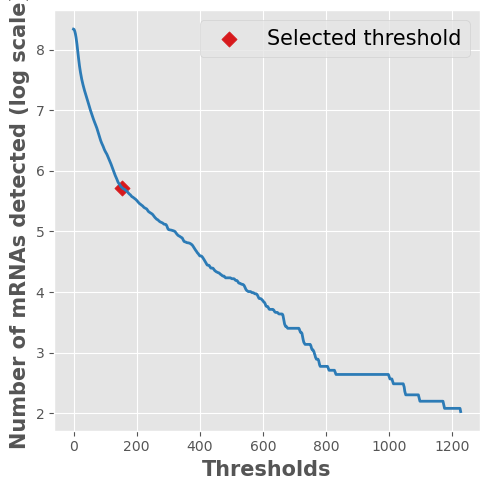

Z-Slice:  5


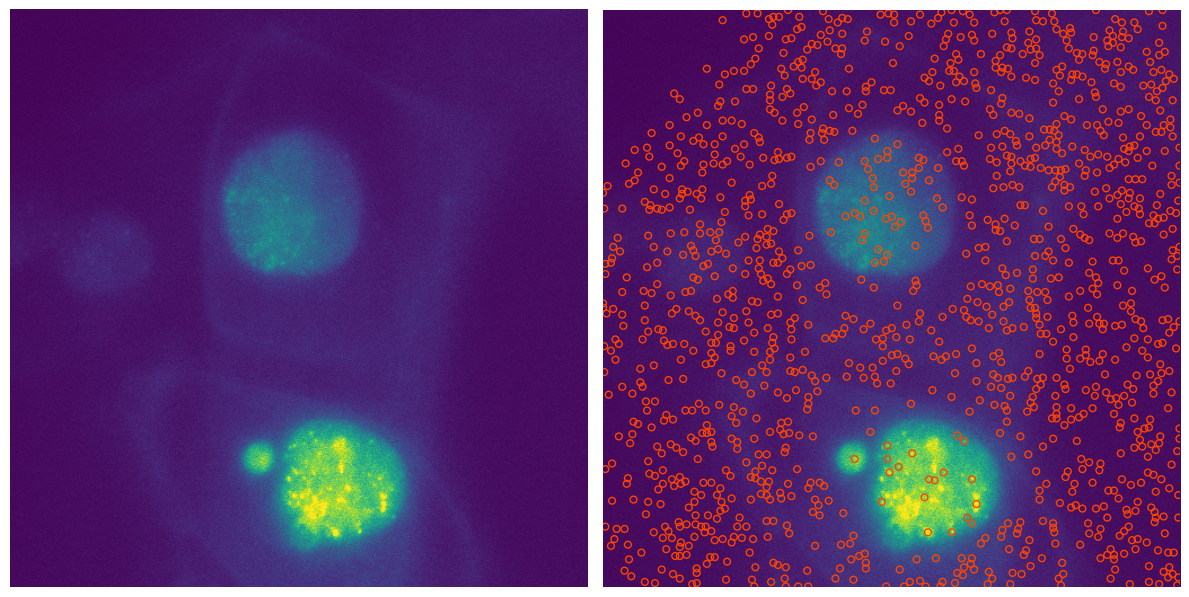

    Intensity threshold for spot detection :  [1131.0]


In [7]:
spot_detection_step.main(id = 0, **kwargs)